## How we anonymized the database


We ran through every table in the database, and made systematic modifications that blanked out any potentially identifying data, and also adding some small changes in data to prevent it being connected to a non-anonymous subset of the dataset.

# Pandas
Here is a useful reference for your exploration: https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.html

In [1]:
#@title Let's install extra dependencies! ok!
!pip install sqlalchemy

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn-bright')
# Set a style for graphs, find others here: https://tonysyu.github.io/raw_content/matplotlib-style-gallery/gallery.html

In [3]:
#@title Making a DataFrame
data = pd.DataFrame({
    'hours_since_breakfast': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    'hunger_level': [0, 0, 0, 2, 5, 8, 10, 10, 0, 0, 0 ],
    'focus_level': [10, 10, 5, 8, 2, 10, 0, 0, 5, 10, 10 ]
})

A DataFrame is like a little spreadsheet:

In [4]:
data

,hours_since_breakfast,hunger_level,focus_level
0,0,0,10
1,1,0,10
2,2,0,5
3,3,2,8
4,4,5,2
5,5,8,10
6,6,10,0
7,7,10,0
8,8,0,5
9,9,0,10


Selecting a column will return a `pandas.Series` object, which is a series of values linked to indices.

In [5]:
data['hunger_level']


0      0
1      0
2      0
3      2
4      5
5      8
6     10
7     10
8      0
9      0
10     0
Name: hunger_level, dtype: int64

We can also select multiple columns:

In [40]:
# This will return another DataFrame object with two columns
data[['hours_since_breakfast', 'focus_level']]

,hours_since_breakfast,focus_level
0,0,10
1,1,10
2,2,5
3,3,8
4,4,2
5,5,10
6,6,0
7,7,0
8,8,5
9,9,10


You can do tons of cool stuff with both `Series` and `DataFrame` objects...

In [41]:
# you can do basic math operations on DataFrame objects and Series objects
data['focus_level']/2 + data['hunger_level'] * data['hours_since_breakfast']

# what does this mean?  I don't know! 1 Micah = 1 Stomach Grumbles Hour

0      5.0
1      5.0
2      2.5
3     10.0
4     21.0
5     45.0
6     60.0
7     70.0
8      2.5
9      5.0
10     5.0
dtype: float64

DataFrames have a lot of useful functions for manipulating data and doing computations.  A full list is [here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.html) (scroll down to *methods*).

For example, getting the mean of a column:

In [42]:
# getting the mean focus level
means = data.mean()

In [43]:
means.mean()

4.848484848484849

In [44]:
# some common statistics for all columns of our DataFrame.
# (the output of this function is also a DataFrame!)
data.describe()

,hours_since_breakfast,hunger_level,focus_level
count,11.000000,11.000000,11.000000
mean,5.000000,3.181818,6.363636
std,3.316625,4.261882,4.153859
min,0.000000,0.000000,0.000000
25%,2.500000,0.000000,3.500000
50%,5.000000,0.000000,8.000000
75%,7.500000,6.500000,10.000000
max,10.000000,10.000000,10.000000


Pandas lets DataFrames have meaningful indices.  We can reindex our DataFrame to the `hours_since_breakfast` column:

In [45]:
hours_since_breakfast = pd.to_timedelta(data['hours_since_breakfast'], unit='h')
data_by_hours = data.set_index(hours_since_breakfast)[['focus_level','hunger_level']]

data_by_hours

,focus_level,hunger_level
hours_since_breakfast,,
00:00:00,10,0
01:00:00,10,0
02:00:00,5,0
03:00:00,8,2
04:00:00,2,5
05:00:00,10,8
06:00:00,0,10
07:00:00,0,10
08:00:00,5,0


Now we can take a rolling mean, with a window of 4 hours...

In [46]:
window = pd.Timedelta('4 hours')
smooth_data = data_by_hours.rolling(window).mean()
smooth_data

,focus_level,hunger_level
hours_since_breakfast,,
00:00:00,10.000000,0.00
01:00:00,10.000000,0.00
02:00:00,8.333333,0.00
03:00:00,8.250000,0.50
04:00:00,6.250000,1.75
05:00:00,6.250000,3.75
06:00:00,5.000000,6.25
07:00:00,3.000000,8.25
08:00:00,3.750000,7.00


Let's plot it:

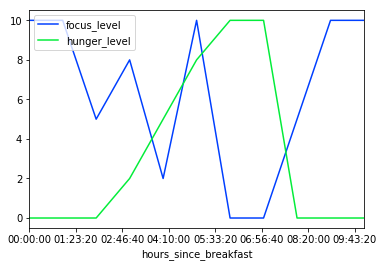

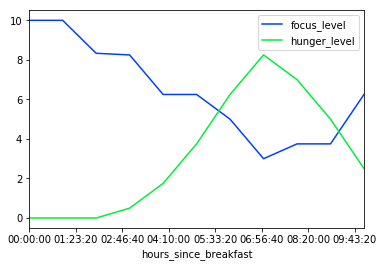

In [47]:
data_by_hours.plot()
smooth_data.plot()

How illuminating! And magical!

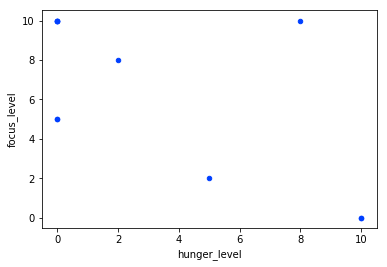

In [48]:
data.plot.scatter(x='hunger_level', y='focus_level')

# Working with Kolibri Data

So far we have worked with example data to get to grips with using Pandas in Jupyter Notebooks. Now we are going to load in some data from an anonymized Kolibri database file, and then try out some analysis on it!

In [6]:
db_path = "sample.sqlite3"
#db_path = "data.sqlite3"
import pandas as pd
from sqlalchemy import create_engine

db_engine = create_engine('sqlite:///{db_path}'.format(db_path=db_path))

blacklist = ["_morango_dirty_bit", "_morango_source_id", "_morango_partition", "dataset_id"]


In [7]:

collections = pd.read_sql_table('kolibriauth_collection', db_engine).drop(blacklist, axis=1)
facilities = collections[collections.kind == 'facility']
classrooms = collections[collections.kind == 'classroom']
groups = collections[collections.kind == 'group']
users = pd.read_sql_table('kolibriauth_facilityuser', db_engine).drop(blacklist, axis=1)
roles = pd.read_sql_table('kolibriauth_role', db_engine).drop(blacklist, axis=1)
membership = pd.read_sql_table('kolibriauth_membership', db_engine).drop(blacklist, axis=1)
content_session_logs = pd.read_sql_table('logger_contentsessionlog', db_engine).drop(blacklist, axis=1)
content_summary_logs = pd.read_sql_table('logger_contentsummarylog', db_engine).drop(blacklist, axis=1)
attempt_logs = pd.read_sql_table('logger_attemptlog', db_engine).drop(blacklist, axis=1)
mastery_logs = pd.read_sql_table('logger_masterylog', db_engine).drop(blacklist, axis=1)
exams = pd.read_sql_table('exams_exam', db_engine).drop(blacklist, axis=1)
exam_logs = pd.read_sql_table('logger_examlog', db_engine).drop(blacklist, axis=1)
exam_attempt_logs = pd.read_sql_table('logger_examattemptlog', db_engine).drop(blacklist, axis=1)
user_session_logs = pd.read_sql_table('logger_usersessionlog', db_engine).drop(blacklist, axis=1)

## You want answers? I want the truth!

In this section we will use pandas to do some example queries on Kolibri data to answer some questions

### How many coaches are using Kolibri?

We might think we would want to count users, but if we look at the users dataframe, there is no information about what role a user plays in there:

In [85]:
# Use .head() to just get the first few rows of the dataframe for quickly checking out the data
users[['full_name','last_login','date_joined','facility_id']].head()

,full_name,last_login,date_joined,facility_id
0,84120d5df3cc075c,2018-08-18 09:26:24.064089,2009-01-01 07:19:22.529668(UTC),37f4d9f1273750edbc1784f624a62c
1,34a8009bcfc1e637,2018-12-04 07:14:13.886316,2009-01-01 07:47:03.642762(UTC),37f4d9f1273750edbc1784f624a62c
2,d8b29758e7c4d384,2018-12-04 07:44:29.649419,2018-08-18 08:35:18.075786(UTC),37f4d9f1273750edbc1784f624a62c
3,7c2223b748710cce,NaT,2018-08-18 08:41:33.090256(UTC),37f4d9f1273750edbc1784f624a62c
4,30b22ddcb730f671,2018-11-28 09:34:15.356216,2018-08-18 10:51:41.982703(UTC),37f4d9f1273750edbc1784f624a62c


In [76]:
# Instead we need to look at the roles data, which shows special roles (admin, coach) assigned to a user.
roles.head()

,id,collection_id,user_id,kind
0,6c2ef85e9237530b86dbe9000c8da8,37f4d9f1273750edbc1784f624a62c,d97291d8ed0d5503aace68044af2a4,admin
1,19a5725c2907543f88e71e02aac40c,37f4d9f1273750edbc1784f624a62c,c81c4f3d67b5594b834daf50ed1231,admin
2,0da0fad9fa60599086ba986675c0e7,37f4d9f1273750edbc1784f624a62c,67291573f0f059a1bb63acd79f534a,admin
3,b7576f82e3d65abdbb64f06ba06e99,37f4d9f1273750edbc1784f624a62c,9d2f13f91d2d575ebe98fe054f8cbf,admin
4,617de75354105158a8478be62fff60,e42d8a5d98ab5ad2b3cf5d4909112c,67291573f0f059a1bb63acd79f534a,coach


In [77]:
roles[roles.kind == 'coach'].kind.count()

2

### But wait, this data is from Nalanda. In Nalanda every coach is currently using an admin account!

In [54]:
roles[roles.kind == 'admin'].kind.count()

4

### How many questions per exam? (note: this question originally also asked about lessons, but there is no lessons data in the Nalanda DB)

In [55]:
exams.head()

,id,title,channel_id,question_count,question_sources,seed,active,archive,collection_id,creator_id
0,7ccb539cb93f591f96e068807b6ae7,d99596895095d0be,37b2c95c302356e8ac53b8d9cab638,10,"[{""number_of_questions"": 10, ""exercise_id"": ""2...",417,False,False,e42d8a5d98ab5ad2b3cf5d4909112c,67291573f0f059a1bb63acd79f534a
1,4d54a40f730f596b823a58b9969b6c,ea797d66d3abdc2b,37b2c95c302356e8ac53b8d9cab638,10,"[{""number_of_questions"": 10, ""exercise_id"": ""2...",510,False,False,226de14b99135a9db373aa3275929e,67291573f0f059a1bb63acd79f534a
2,8ce41098abca5e37a993ffaf57d56c,f1b21184fb5bfb74,37b2c95c302356e8ac53b8d9cab638,6,"[{""number_of_questions"": 3, ""exercise_id"": ""02...",96,False,False,e42d8a5d98ab5ad2b3cf5d4909112c,67291573f0f059a1bb63acd79f534a
3,a25e8a996dd5546188d7c9df4aa862,3b3faf51d16ea29f,37b2c95c302356e8ac53b8d9cab638,6,"[{""number_of_questions"": 3, ""exercise_id"": ""02...",96,False,False,226de14b99135a9db373aa3275929e,67291573f0f059a1bb63acd79f534a
4,9fc4126654cd5916afd0e9c30237c4,edffa083aa153d1f,37b2c95c302356e8ac53b8d9cab638,6,"[{""number_of_questions"": 6, ""exercise_id"": ""b9...",883,False,False,e42d8a5d98ab5ad2b3cf5d4909112c,67291573f0f059a1bb63acd79f534a


Looking at the exams, it seems like we can just directly check the number of questions with the questions_count attribute! Let's look at that.

In [56]:
# Mean question count
exams.question_count.mean()

9.777777777777779

In [57]:
# Standard deviation of question count
exams.question_count.std()

4.294699575575042

In [58]:
# Median question count
exams.question_count.median()

10.0

In [59]:
# Modal question count
exams.question_count.mode()

0     6
1    15
dtype: int64

That's weird - we have questions with a question count of 0?!
Let's take a look at what is going on there, sounds funky.


In [60]:
# We can only look at data for particular cases by 'boolean indexing', this will only show us rows where question count is 0
exams[exams.question_count == 0]

,id,title,channel_id,question_count,question_sources,seed,active,archive,collection_id,creator_id


That's odd - so there aren't any that have question_count of 0. Let's look at that mode again.

In [61]:
len(exams.question_count.mode())

2

So, it only has a length of 1! So there is only one result.

What's happening?

Because a mode **can** have more than one value (bimodal, etc.) the .mode() method does not return a single value like median and mean, but instead returns a Pandas Series. The 0 we saw next to the 50 is actually the index number of that Series.

So there is only one mode, and the mode is 50.

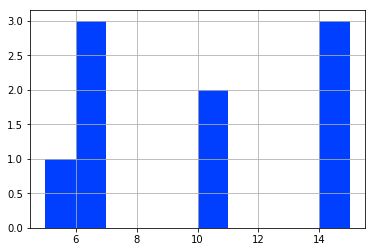

In [62]:
# A histogram clearly shows that the mode is indeed 50, with three exams having that question count.
exams.question_count.hist()

### How much time is actually spent on each kind of resource?

Fortunately, we record the content kind in the content session log, so we can tell some things about the content that is engaged with. 

However, to actually know what the content is, we would need access to data from Studio to cross reference (especially for a Nalanda database, where the content data has not been imported into the database).

In [158]:
content_session_logs.head()
content_session_logs.loc[content_session_logs['content_id'] == '34d5d85546d5584bbc95aa119c2eec']

,id,content_id,channel_id,end_timestamp,time_spent,progress,kind,extra_fields,user_id,start_timestamp
2,dc67704faf1e5d88922d0c5cd7adf0,34d5d85546d5584bbc95aa119c2eec,37b2c95c302356e8ac53b8d9cab638,2018-08-18 10:54:15.502000(UTC),135.908468,0.257234,exercise,678693baa9f54233,c5ef36b567e85065931053f3d5f523,2018-08-18 10:17:37.871000(UTC)
3,830633563826545794ec131116ed15,34d5d85546d5584bbc95aa119c2eec,37b2c95c302356e8ac53b8d9cab638,2018-08-18 10:42:05.663000(UTC),783.462780,0.260762,exercise,3a80f333947cd8eb,c5ef36b567e85065931053f3d5f523,2018-08-18 10:53:00.636000(UTC)
4,fa9ce35d24eb53e7a8ec84bce172eb,34d5d85546d5584bbc95aa119c2eec,37b2c95c302356e8ac53b8d9cab638,2018-08-18 11:22:23.325000(UTC),0.264674,0.260043,exercise,5a89dbfd706686b6,c5ef36b567e85065931053f3d5f523,2018-08-18 10:59:56.928000(UTC)
5,8f3bf61e8e5f5104ad958cd8e0a3b6,34d5d85546d5584bbc95aa119c2eec,37b2c95c302356e8ac53b8d9cab638,2018-08-18 09:55:43.303000(UTC),0.000000,0.000000,exercise,ca1b4e822d14d675,c5ef36b567e85065931053f3d5f523,2018-08-18 09:54:04.303000(UTC)
6,237bb8f4be005728aa58e2fd4d6509,34d5d85546d5584bbc95aa119c2eec,37b2c95c302356e8ac53b8d9cab638,2018-08-18 11:20:13.029000(UTC),391.687930,0.000000,exercise,9d33d93483992c8e,c5ef36b567e85065931053f3d5f523,2018-08-18 09:56:55.489000(UTC)


We can see that there is a time_spent property, and also a kind property. We can use each of these to work out the total time for each content kind.

In [96]:
content_session_logs[['id','time_spent','progress','kind']].head()

,id,time_spent,progress,kind
0,432d87395241549a829baff8e05695,0.000000,0.000000,exercise
1,5205c00b9dd85be99350cef49c29fa,0.000000,0.000000,exercise
2,dc67704faf1e5d88922d0c5cd7adf0,135.908468,0.257234,exercise
3,830633563826545794ec131116ed15,783.462780,0.260762,exercise
4,fa9ce35d24eb53e7a8ec84bce172eb,0.264674,0.260043,exercise


In [64]:
# Exercise
content_session_logs[content_session_logs.kind == 'exercise'].time_spent.sum()

297519.0763843533

Well, as anyone can see from that number in seconds, that's nearly a tenth of a year spent on exercises!

But, seriously, we should probably try to transform that data into something more user friendly.

Let's use Pandas functions to make this better.

In [65]:
# Exercise with pd.to_timedelta:
time_spent_exercises = content_session_logs[content_session_logs.kind == 'exercise'].time_spent
pd.to_timedelta(time_spent_exercises, unit='s').sum()

Timedelta('3 days 10:38:39.076384')

In [66]:
# Video with pd.to_timedelta:
time_spent_on_videos = content_session_logs[content_session_logs.kind == 'video'].time_spent
pd.to_timedelta(time_spent_on_videos, unit='s').sum()

Timedelta('0 days 03:19:40.653408')

In [67]:
# Document with pd.to_timedelta:
time_spent_document = content_session_logs[content_session_logs.kind == 'document'].time_spent
pd.to_timedelta(time_spent_document, unit='s').sum()

Timedelta('0 days 00:00:00')

In [68]:
# Audio with pd.to_timedelta:
time_spent_audio = content_session_logs[content_session_logs.kind == 'audio'].time_spent
pd.to_timedelta(time_spent_audio, unit='s').sum()

Timedelta('0 days 00:00:00')

In [69]:
# HTML5 with pd.to_timedelta:
time_spent_html5 = content_session_logs[content_session_logs.kind == 'html5'].time_spent
pd.to_timedelta(time_spent_html5, unit='s').sum()

Timedelta('0 days 00:00:00')

The ratio of time spent on exercises vs. total session time:

In [105]:
t = content_session_logs[content_session_logs.kind == 'exercise'].time_spent
time_spent_exercises = pd.to_timedelta(t, unit='s').sum()


session_durations = (user_session_logs['last_interaction_timestamp'] - user_session_logs['start_timestamp'])
time_spent_sessions_total = session_durations.sum()

time_spent_exercises/time_spent_sessions_total*100

SyntaxError: unexpected EOF while parsing (<ipython-input-105-e74e25e4dda6>, line 5)

In [152]:
import datetime
format = '%Y-%m-%d %H:%M:%S.%z'
#datetime.datetime.fromtimestamp(user_session_logs['last_interaction_timestamp'][0])
print(user_session_logs['start_timestamp'][0][:-5])
datetime.datetime.strptime(user_session_logs['last_interaction_timestamp'][0][:-6],format)

2018-08-10 17:16:16.465814


ValueError: time data '2018-08-10 18:21:55.86378' does not match format '%Y-%m-%d %H:%M:%S.%z'

### Looking at user session durations over time

In [153]:
time_index = pd.to_datetime(user_session_logs['start_timestamp'])
sessions = user_session_logs.set_index(time_index)
durations = (sessions['last_interaction_timestamp'] - sessions['start_timestamp'])
durations.plot()

ValueError: ('Unknown string format:', '2018-08-10 17:16:16.465814(UTC)')

Zooming in...

In [139]:
durations.plot(xlim=(pd.to_datetime('2017-12'), pd.to_datetime('2018-01')))

NameError: name 'durations' is not defined

We can also plot a rolling sum of total session duration over a window:

In [ ]:
# Pandas doesn't let us take a rolling mean of Timedelta...
# (see here https://stackoverflow.com/a/44616595 )
# Let's the Timedeltas to hours:
duration_hours = durations.dt.total_seconds()/60/60
window = pd.Timedelta('7 days')
duration_hours.rolling(window).sum().plot()

Unfortunately, Pandas built-in plotting helpers don't let us make scatterplots of Series data. 

So we'll need to use matplotlib directly for this...


In [ ]:
import matplotlib.pyplot as plt
plt.plot_date(durations.index, durations)

In [ ]:
user_session_logs['time_spent'] = user_session_logs.last_interaction_timestamp - user_session_logs.start_timestamp

In [ ]:
user_session_logs.head()

In [ ]:
user_session_logs.time_spent.astype('timedelta64[m]').hist()

In [ ]:
content_summary_logs

In [ ]:
content_summary_logs[content_summary_logs.time_spent > 15].groupby('content_id').content_id.count().sort_values()

In [ ]:
content_summary_logs[content_summary_logs.time_spent > 15].groupby('content_id').time_spent.sum().sort_values()

In [ ]:
attempt_logs.head()

### histogram of how many unique exercises the learners in the facility have completed

In [ ]:
content_summary_logs[content_summary_logs.kind == 'exercise'].groupby('content_id').content_id.count().hist()

In [ ]:
content_session_logs[~content_session_logs.user_id.isnull()]